# Exercise 12.1 

## Download Dataset

Go course site and download the 
- ```lab_images.npz``` dataset which contains all of the images

## Import Libraries
Python requires importing libraries and functions you need to access specific tools like science (scipy), linear algebra (numpy), and graphics (matplotlib). These libraries can be installed using the ```pip``` command line tool. Alternatively you can install an python distribution like [Anaconda](https://www.continuum.io/downloads) or [Canopy](https://www.enthought.com/products/canopy/)  which have these and many other standard package pre-installed.

## Deep Learning Libraries
To perform deep learning you will need additional libraries that you will have to install yourself using the ```pip``` tool. These are

### CPU / GPU Computational Engines
- ```theano``` a python-only tool which compiled CPU and GPU code in the background
or 
- ```tensorflow``` a python-wrapper for a C++ tool which uses compiled CPU and GPU code to execute more efficiently

### Frameworks

- ```keras``` a tool that makes constructing and sharing networks much easier that supports theano and tensorflow as underlying computing engines


## Tasks
1. Train the network by running the _fast fit_ chunk a number of times (100 in total)
1. Why does the loss function sometimes show peaks? 
1. What happens when you try to train the network again using the entire dataset, why does the loss go up?
1. How might you make the network better at classifying roads?
1. What effect do the ```MaxPooling2d``` layers have on the output?
1. How can you interpret the kernel values? What might you look for the make sure they are meaningful?

In [2]:
import numpy as np
import skimage.transform
import scipy
import matplotlib.pyplot as plt


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt # plotting
from skimage.io import imread # read in images
from skimage.segmentation import mark_boundaries # mark labels
from sklearn.metrics import roc_curve, auc # roc curve tools
from skimage.color import label2rgb
import numpy as np # linear algebra / matrices
# make the notebook interactive
from ipywidgets import interact, interactive, fixed 
import ipywidgets as widgets #add new widgets
from IPython.display import display

%matplotlib inline


In [190]:
# load in the image tiles and make the shape correct
with np.load('lab_images.npz') as in_data:
    col_imgs = in_data['col_imgs'].swapaxes(1,3).swapaxes(2,3)
    # normalized floating point version
    fcol_imgs = (col_imgs.astype(np.float32)-127.0)/127
    lab_imgs = np.expand_dims(in_data['lab_imgs'],1)
    # normalized floating point values
    flab_imgs = lab_imgs.astype(np.float32)/255
    fl_flab_imgs = flab_imgs.reshape((lab_imgs.shape[0],-1))
    print('Color Shape',fcol_imgs.shape,'Label Shape',lab_imgs.shape,'Flat label Shape',fl_flab_imgs.shape)

Color Shape (1000, 3, 96, 96) Label Shape (1000, 1, 96, 96) Flat label Shape (1000, 9216)


## Show sample tiles

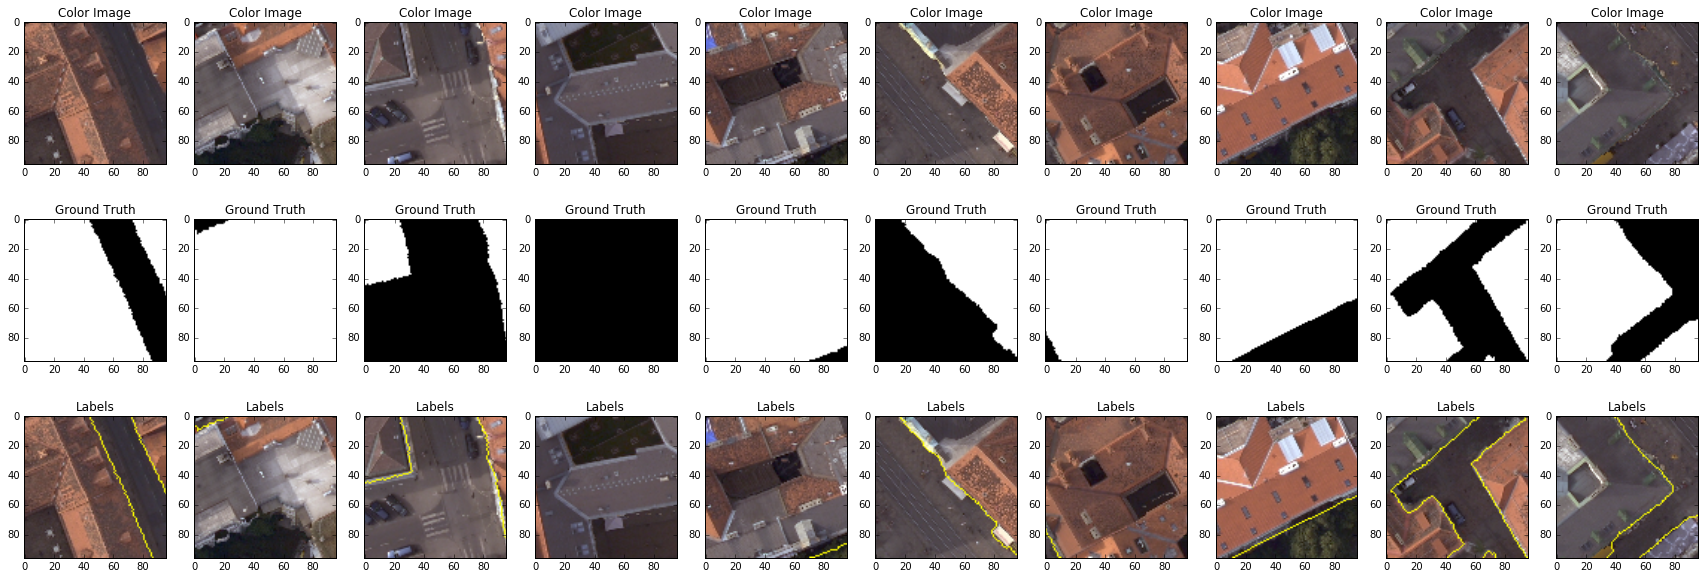

In [69]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(3,10,figsize = (30,10))
for (cax1,wcimg,cax2,wlimg,cax3) in zip(ax1,col_imgs,ax2,lab_imgs,ax3):
    scimg = wcimg.swapaxes(0,2).swapaxes(0,1)
    slimg = wlimg.squeeze()
    cax1.imshow(scimg) # show the color image
    cax1.set_title("Color Image")
    cax2.imshow(slimg, cmap='gray') # show the segments
    cax2.set_title("Ground Truth")
    cax3.imshow(mark_boundaries(scimg,slimg))
    cax3.set_title("Labels")

In [191]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
img_cnt, img_channels, img_rows, img_cols = col_imgs.shape
batch_size = 16
# for the first layer
patch_size = 8
depth = 8
num_hidden = 64
DEEPER_LAYER = False
DEEPEST_LAYER = False

In [192]:
model = Sequential()

model.add(Convolution2D(depth, patch_size, patch_size, border_mode='same',
                        input_shape=(img_channels, img_rows, img_cols),
                       W_regularizer = l2(l=0.02)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(3, 3), strides = (1,1), border_mode='same')) # keep the image size the same


if DEEPER_LAYER:
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
if DEEPEST_LAYER:
    model.add(Convolution2D(96, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))    

model.add(Convolution2D(1, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides = (1,1), border_mode='same')) # keep the image size the same

model.add(Activation('sigmoid')) # bound from zero to one

In [193]:
# overview of network
map(lambda x: (x.name,('in:',x.input_shape[1:],'out:',x.output_shape[1:])),model.layers)

[('convolution2d', ('in:', (3, 96, 96), 'out:', (8, 96, 96))),
 ('activation', ('in:', (8, 96, 96), 'out:', (8, 96, 96))),
 ('dropout', ('in:', (8, 96, 96), 'out:', (8, 96, 96))),
 ('maxpooling2d', ('in:', (8, 96, 96), 'out:', (8, 96, 96))),
 ('convolution2d', ('in:', (8, 96, 96), 'out:', (1, 96, 96))),
 ('activation', ('in:', (1, 96, 96), 'out:', (1, 96, 96))),
 ('maxpooling2d', ('in:', (1, 96, 96), 'out:', (1, 96, 96))),
 ('activation', ('in:', (1, 96, 96), 'out:', (1, 96, 96)))]

In [194]:
# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=2e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', # since there are only two classes (road or not)
              optimizer=sgd)

In [287]:
# a fast fit
# fit the model with the normalized images and the labels
fit_history = model.fit(fcol_imgs[:100,:,:,:],flab_imgs[:100,:],batch_size = batch_size, nb_epoch = 20, shuffle = True)

Epoch 1/20
100/100 [==============================] - 1s - loss: 0.4085     
Epoch 2/20
100/100 [==============================] - 1s - loss: 0.3960     
Epoch 3/20
100/100 [==============================] - 2s - loss: 0.3877     
Epoch 4/20
100/100 [==============================] - 2s - loss: 0.3840     
Epoch 5/20
100/100 [==============================] - 1s - loss: 0.3849     
Epoch 6/20
100/100 [==============================] - 1s - loss: 0.3859     
Epoch 7/20
100/100 [==============================] - 2s - loss: 0.5218     
Epoch 8/20
100/100 [==============================] - 1s - loss: 0.4997     
Epoch 9/20
100/100 [==============================] - 1s - loss: 0.4223     
Epoch 10/20
100/100 [==============================] - 1s - loss: 0.4024     
Epoch 11/20
100/100 [==============================] - 1s - loss: 0.4018     
Epoch 12/20
100/100 [==============================] - 1s - loss: 0.3951     
Epoch 13/20
100/100 [==============================] - 1s - loss: 0.3921 

In [281]:
# fit the model with the normalized images and the labels
fit_history = model.fit(fcol_imgs,flab_imgs,batch_size = batch_size, nb_epoch = 5, shuffle = True)

Epoch 1/5
1000/1000 [==============================] - 17s - loss: 0.4128    
Epoch 2/5
1000/1000 [==============================] - 19s - loss: 0.4121    
Epoch 3/5
1000/1000 [==============================] - 23s - loss: 0.4076    
Epoch 4/5
1000/1000 [==============================] - 21s - loss: 0.4090    
Epoch 5/5
1000/1000 [==============================] - 18s - loss: 0.4046    


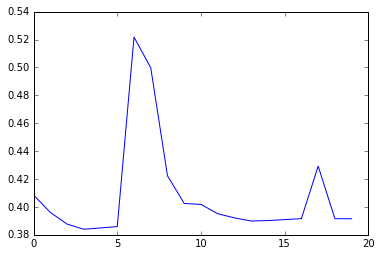

In [288]:
%matplotlib inline
plt.plot(fit_history.history['loss'])

In [289]:
# predict the output layer of the images
pred_fimg = model.predict_on_batch(fcol_imgs)
pred_img = pred_fimg[0].reshape((fcol_imgs.shape[0],lab_imgs.shape[2],lab_imgs.shape[3]))

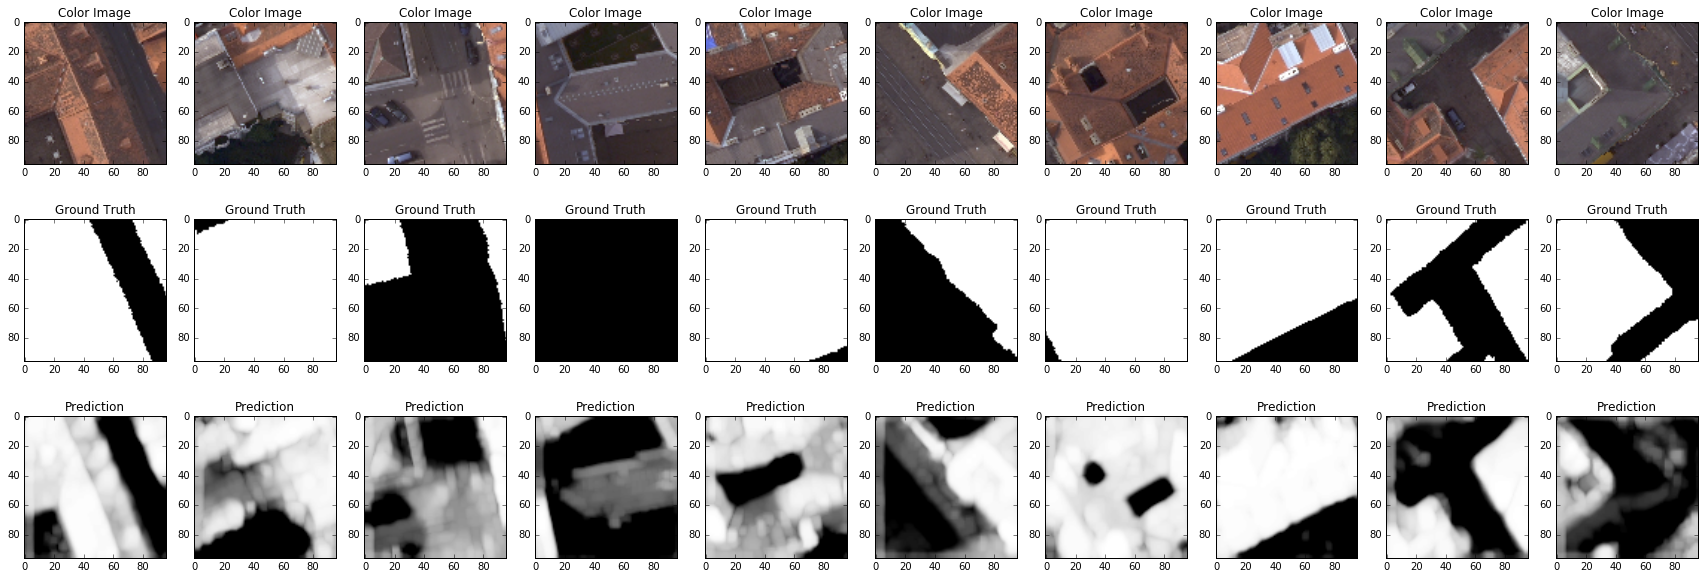

In [290]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(3,10,figsize = (30,10))
for (cax1,wcimg,cax2,wlimg,cax3,wpimg) in zip(ax1,col_imgs,ax2,lab_imgs,ax3,pred_img):
    scimg = wcimg.swapaxes(0,2).swapaxes(0,1)
    slimg = wlimg.squeeze()
    spimg = (wpimg.squeeze()*255).astype(np.uint8)
    cax1.imshow(scimg) # show the color image
    cax1.set_title("Color Image")
    cax2.imshow(slimg, cmap='gray') # show the segments
    cax2.set_title("Ground Truth")
    cax3.imshow(spimg, cmap='gray')
    cax3.set_title("Prediction")

## Show some of the learned coefficients / convolution kernels

In [285]:
# overview of learned weights
map(lambda x: (x.name,('in:',x.input_shape[1:],'weight_shape:',x.W.get_value().shape)),
    filter(lambda x: x.__dict__.has_key('W'),model.layers))

[('convolution2d', ('in:', (3, 96, 96), 'weight_shape:', (8, 3, 8, 8))),
 ('convolution2d', ('in:', (8, 96, 96), 'weight_shape:', (1, 8, 3, 3)))]

We focus just on the first layer since they correspond to the input color images and are easiest to interpret. We see that they show gradients and basic edges. Longer training and more extensive datasets will significantly improve these kernels

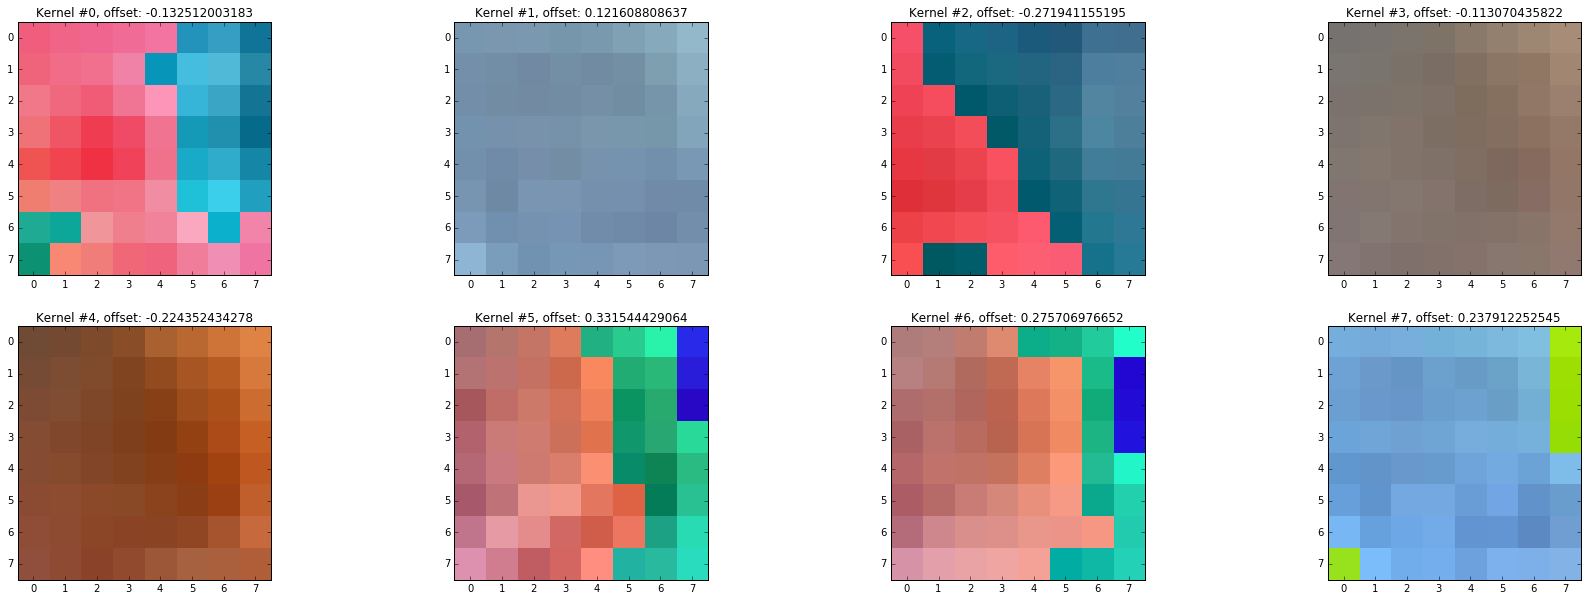

In [291]:
%matplotlib inline
first_weights = model.layers[0].W.get_value()
first_offsets = model.layers[0].b.get_value()
# normalize the values
s_weights = (127*first_weights/(3*np.abs(first_weights).mean())+127).clip(0,255).astype(np.uint8)
fig, ax = plt.subplots(2,4,figsize = (30,10))
for i, (cax, cweights, coffset) in enumerate(zip(ax.flatten(),s_weights,first_offsets)):
    cax.imshow((coffset*127+cweights).astype(np.uint8).swapaxes(0,2).swapaxes(0,1), interpolation = 'nearest')
    cax.set_title('Kernel #{}, offset: {}'.format(i,coffset))